### 1. Install R packages

Uncomment section below if running for the first time

In [1]:
# if (!requireNamespace("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")
# BiocManager::install("dada2")
# install.packages("magrittr")
# install.packages("stringr")
# install.packages("data.table")
# install.packages("broom")
# install.packages("qualpalr")
# install.packages("seqinr")

### 2. Load required libraries

In [2]:
library(dada2)
library(stringr)
library(data.table)
# library(broom)
library(qualpalr)
library(ShortRead)
library(Biostrings)
library(seqinr)

Loading required package: Rcpp

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: BiocParallel

Loading required package: Biostrings

Loading required package: S4Vectors

Loading required package: stats4


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:data.table’:

    first, second


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading

### 3. File path setup

In [3]:
rawpath <- "raw"
wdpath <- "/home/allie/domhain/2022-HIV_oral_microbiome/01-read_processing/" # change to where git repository was cloned
fnFs <- sort(list.files(rawpath, pattern="_R1_001.fastq.gz", full.names=T))
fnRs <- sort(list.files(rawpath, pattern="_R2_001.fastq.gz", full.names=T))
sample.names <- sapply(strsplit(basename(fnFs), "_"), `[`, 1)
head(sample.names, 50)
paste("Number of input samples: ", length(sample.names))

[1] "2L13-PD1"         "2L13-PE1"         "2L13-PF1"         "2L17-PE1"        
 [5] "2L17-PF1"         "2L2-PD1"          "2L2-PE1"          "2L23-PD1"        
 [9] "2L23-PE1"         "2L3-PF1"          "2L4-PF1"          "2L46-PE1"        
[13] "2L46-PF1"         "2L47-PE1"         "2L47-PF1"         "2L49-PF1"        
[17] "2L52-PF1"         "2L59-PF1"         "2L60-PE1"         "2L60-PF1"        
[21] "2L61-PD1"         "2L61-PE1"         "2L61-PF1"         "2L62-PF1"        
[25] "2L63-PE1"         "2L63-PF1"         "2L64-PD1"         "2L64-PE1"        
[29] "2L67-PF1"         "2L69-PF1"         "2L70-PF1"         "2L72-PE1"        
[33] "2L72-PF1"         "2L75-PD1"         "2L75PE1"          "4L59-PF1"        
[37] "DM00001V1PQ"      "DM00002V1PQ"      "DM00004V1PQ55"    "DM00004V1PQ65"   
[41] "DM00005V1PQ36-1"  "DM00005V1PQ46-2"  "DM00006V1PQ1"     "DM00007V1PQ1"    
[45] "DM00008V1PQ16-2"  "DM00008V1PQ26-1"  "DM00009V1PQ55"    "DM00009V1PQ65"   
[49] "DM00010V1PQ54"    "DM00010V1PQ64-65"

[1] "Number of input samples:  969"

### 4. Plot quality scores

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


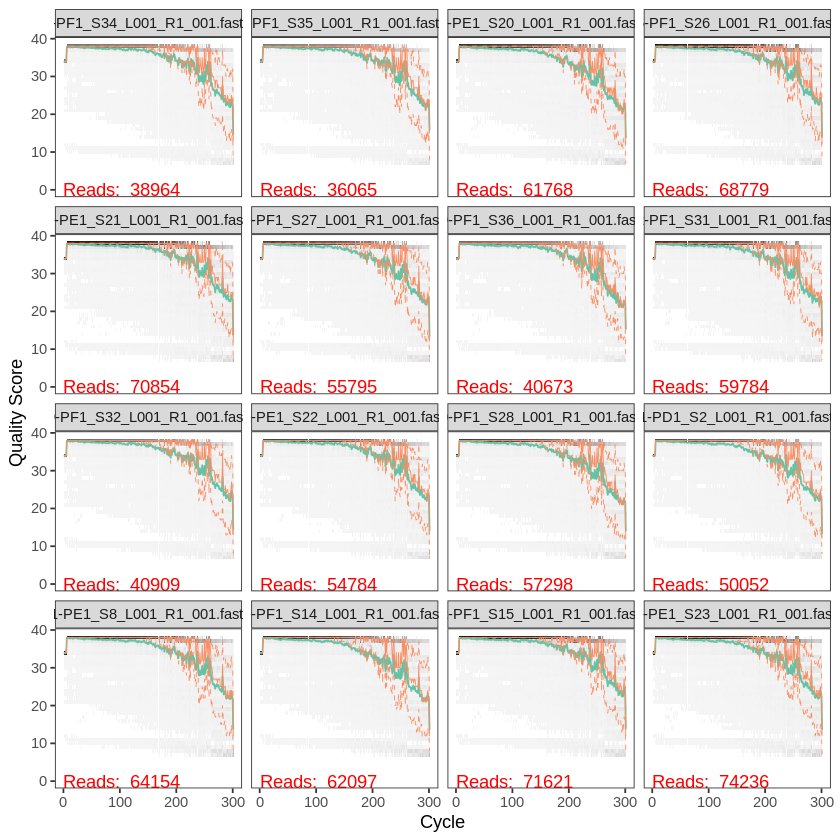

png 
  2

png 
  2

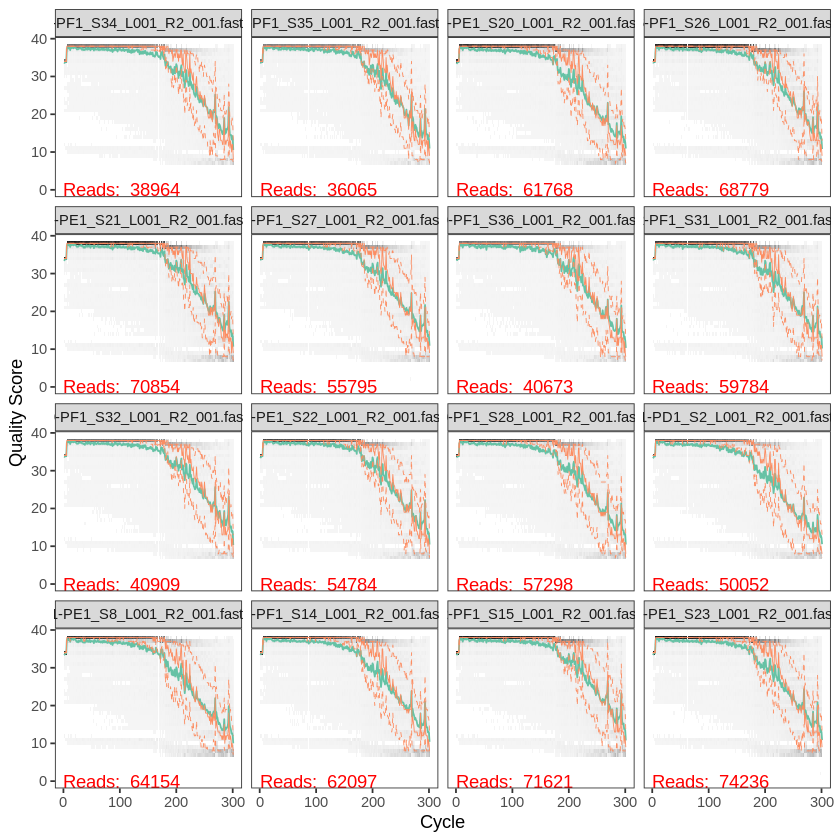

In [4]:
system("mkdir img") # ignore warning
fwdqual <- plotQualityProfile(fnFs[10:25])
revqual <- plotQualityProfile(fnRs[10:25])
fwdqual
revqual

pdf(paste(wdpath, "img/", "forward_quality_plot.pdf", sep=""))
fwdqual
dev.off()
pdf(paste(wdpath, "img/", "reverse_quality_plot.pdf", sep=""))
revqual
dev.off()


### 5. Preliminary filter (removes sequences with uncalled bases)

In [5]:
fnFs.filtN <- file.path(rawpath, "filtN", basename(fnFs)) # Put N-filtered files in filtN/ subdirectory
fnRs.filtN <- file.path(rawpath, "filtN", basename(fnRs))
filterAndTrim(fnFs, fnFs.filtN, fnRs, fnRs.filtN, maxN = 0, multithread = TRUE, compress = TRUE)

Creating output directory: raw/filtN



### 6. Primer removal 

In [6]:
cutadapt <- as.character(system("which cutadapt", intern=T))
system("cutadapt --version")
path.cut <- file.path(rawpath, "cutadapt")
if(!dir.exists(path.cut)) dir.create(path.cut)
fnFs.cut <- file.path(path.cut, basename(fnFs))
fnRs.cut <- file.path(path.cut, basename(fnRs))
FWD.RC <- dada2:::rc("MAYGARAARMGNATGYTNCARGA")
REV.RC <- dada2:::rc("GMCATYTGRTCNCCRTCRAA")
# Trim FWD and the reverse-complement of REV off of R1 (forward reads)
R1.flags <- paste("-g", "MAYGARAARMGNATGYTNCARGA", "-a", REV.RC) 
# Trim REV and the reverse-complement of FWD off of R2 (reverse reads)
R2.flags <- paste("-G", "GMCATYTGRTCNCCRTCRAA", "-A", FWD.RC) 
for(i in seq_along(fnFs)) {
  system2(cutadapt, args = c("--cores=0", R1.flags, R2.flags, "-n", 2,"-o", fnFs.cut[i], "-p", fnRs.cut[i], fnFs.filtN[i], fnRs.filtN[i]))
}
cutFs <- sort(list.files(path.cut, pattern = "R1", full.names = TRUE))
cutRs <- sort(list.files(path.cut, pattern = "R2", full.names = TRUE))

### 7. Filter and trim reads

In [7]:
filtFs <- file.path(path.cut, "filtered", basename(cutFs))
filtRs <- file.path(path.cut, "filtered", basename(cutRs))
out <- filterAndTrim(cutFs, filtFs, cutRs, filtRs, trimRight=25, maxN=c(0,0), maxEE=c(4,6), rm.phix=TRUE, matchIDs=TRUE, compress=TRUE, multithread=TRUE)
retained <- as.data.frame(out)
retained$percentage_retained <- retained$reads.out/retained$reads.in*100
retained

Creating output directory: raw/cutadapt/filtered



,reads.in,reads.out,percentage_retained
,<dbl>,<dbl>,<dbl>
2L13-PD1_S1_L001_R1_001.fastq.gz,53293,43742,82.07832
2L13-PE1_S7_L001_R1_001.fastq.gz,51802,41455,80.02587
2L13-PF1_S13_L001_R1_001.fastq.gz,50704,44991,88.73264
2L17-PE1_S19_L001_R1_001.fastq.gz,56847,50544,88.91234
2L17-PF1_S25_L001_R1_001.fastq.gz,56009,49541,88.45186
2L2-PD1_S4_L001_R1_001.fastq.gz,50309,40624,80.74897
2L2-PE1_S10_L001_R1_001.fastq.gz,62524,54860,87.74231
2L23-PD1_S5_L001_R1_001.fastq.gz,40489,33113,81.78271
2L23-PE1_S11_L001_R1_001.fastq.gz,60126,48884,81.30260


### 8. Learn and plot error rates

130529301 total bases in 524550 reads from 11 samples will be used for learning the error rates.
107574606 total bases in 426378 reads from 16 samples will be used for learning the error rates.


Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


png 
  2

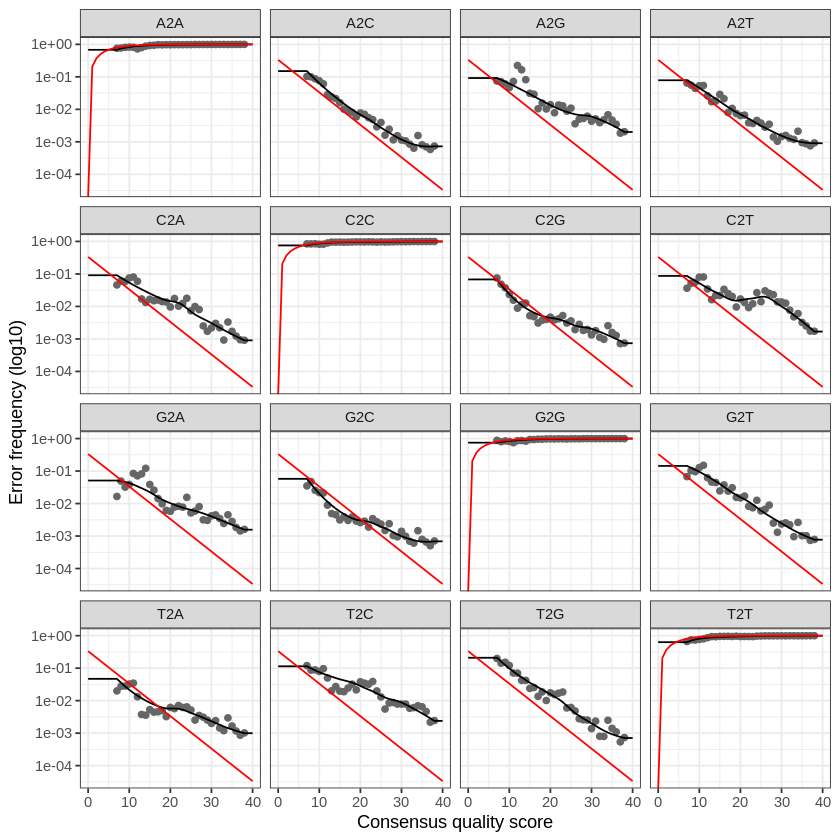

In [8]:
set.seed(12349)
errF <- learnErrors(filtFs, multithread=T, random=T)
errR <- learnErrors(filtRs, multithread=T, random=T)
err.f.plt <- plotErrors(errF, nominalQ=TRUE) 
err.f.plt
pdf(paste(wdpath, "img/", "error_plot.pdf", sep=""))
err.f.plt
dev.off()

### 9. Dereplication

In [9]:
derepFs <- derepFastq(filtFs, verbose=TRUE)
derepRs <- derepFastq(filtRs, verbose=TRUE)
# reassign sample names
sample.names <- sapply(strsplit(basename(filtFs), "_"), `[`, 1)
names(derepFs) <- sample.names
names(derepRs) <- sample.names

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/2L13-PD1_S1_L001_R1_001.fastq.gz

Encountered 15760 unique sequences from 43742 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/2L13-PE1_S7_L001_R1_001.fastq.gz

Encountered 15625 unique sequences from 41455 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/2L13-PF1_S13_L001_R1_001.fastq.gz

Encountered 15843 unique sequences from 44991 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/2L17-PE1_S19_L001_R1_001.fastq.gz

Encountered 17437 unique sequences from 50544 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/2L17-PF1_S25_L001_R1_001.fastq.gz

Encountered 17417 unique sequences from 49541 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/2L2-PD1_S4_L001_R1_001.fastq.gz

Encountered 14119 unique sequences from 4

Encountered 4445 unique sequences from 17120 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00010V1PQ54_S13_L001_R1_001.fastq.gz

Encountered 4755 unique sequences from 20088 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00010V1PQ64-65_S14_L001_R1_001.fastq.gz

Encountered 719 unique sequences from 1860 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00011V1PQ55-1_S15_L001_R1_001.fastq.gz

Encountered 5142 unique sequences from 20948 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00012V1PQ1_S16_L001_R1_001.fastq.gz

Encountered 11860 unique sequences from 54412 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00013V1PQ65-3_S17_L001_R1_001.fastq.gz

Encountered 7104 unique sequences from 29611 total sequences read.

Dereplicating sequence entries in Fastq file: r

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00027V1PQ65-1_S59_L001_R1_001.fastq.gz

Encountered 6409 unique sequences from 25594 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00028V1PQ16-1_S60_L001_R1_001.fastq.gz

Encountered 11035 unique sequences from 43734 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00028V1PQ26-1_S61_L001_R1_001.fastq.gz

Encountered 10029 unique sequences from 38393 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00029V1PQ26-1_S62_L001_R1_001.fastq.gz

Encountered 10606 unique sequences from 52424 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00029V1PQ31-1_S63_L001_R1_001.fastq.gz

Encountered 11499 unique sequences from 43693 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00030V1PQ31-1_S64_L001_R1_001.fastq.

Encountered 12181 unique sequences from 44520 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00044V1PQ55_S106_L001_R1_001.fastq.gz

Encountered 17294 unique sequences from 69077 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00045V1PQ55_S107_L001_R1_001.fastq.gz

Encountered 14039 unique sequences from 52549 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00045V1PQ65_S108_L001_R1_001.fastq.gz

Encountered 13309 unique sequences from 50151 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00045V1PQ75_S109_L001_R1_001.fastq.gz

Encountered 12672 unique sequences from 49361 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00046V1PQ26_S110_L001_R1_001.fastq.gz

Encountered 12341 unique sequences from 45868 total sequences read.

Dereplicating sequence entries in Fastq f

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00060V1PQ26_S151_L001_R1_001.fastq.gz

Encountered 13975 unique sequences from 58915 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00060V1PQ75_S152_L001_R1_001.fastq.gz

Encountered 19331 unique sequences from 67299 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00061V1PQ16_S153_L001_R1_001.fastq.gz

Encountered 13111 unique sequences from 45287 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00061V1PQ65_S154_L001_R1_001.fastq.gz

Encountered 15909 unique sequences from 64700 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00062V1PQ55_S155_L001_R1_001.fastq.gz

Encountered 8780 unique sequences from 31877 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00062V1PQ75_S156_L001_R1_001.fastq.gz

En

Encountered 7123 unique sequences from 18664 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00077V1PQ31_S54_L001_R1_001.fastq.gz

Encountered 9333 unique sequences from 24001 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00077V1PQ54_S55_L001_R1_001.fastq.gz

Encountered 15482 unique sequences from 41238 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00078V1PQ11_S56_L001_R1_001.fastq.gz

Encountered 13039 unique sequences from 36228 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00078V1PQ32_S57_L001_R1_001.fastq.gz

Encountered 7769 unique sequences from 20632 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00079V1PQ11_S58_L001_R1_001.fastq.gz

Encountered 6724 unique sequences from 16593 total sequences read.

Dereplicating sequence entries in Fastq file: raw/

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00096V1PQ26_S102_L001_R1_001.fastq.gz

Encountered 13391 unique sequences from 36795 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00096V1PQ36_S103_L001_R1_001.fastq.gz

Encountered 12676 unique sequences from 30905 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00097V1PQ16_S104_L001_R1_001.fastq.gz

Encountered 15999 unique sequences from 39559 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00097V1PQ26_S105_L001_R1_001.fastq.gz

Encountered 16544 unique sequences from 43702 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00098V1PQ55_S106_L001_R1_001.fastq.gz

Encountered 13556 unique sequences from 33881 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00098V1PQ65_S107_L001_R1_001.fastq.gz

E

Encountered 1653 unique sequences from 4545 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00117V1PQ16_S152_L001_R1_001.fastq.gz

Encountered 17530 unique sequences from 55057 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00118V1PQ16_S153_L001_R1_001.fastq.gz

Encountered 17401 unique sequences from 43209 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00118V1PQ26_S154_L001_R1_001.fastq.gz

Encountered 14351 unique sequences from 38296 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00118V1PQ55_S155_L001_R1_001.fastq.gz

Encountered 15798 unique sequences from 39341 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00118V1PQ65_S156_L001_R1_001.fastq.gz

Encountered 16660 unique sequences from 41657 total sequences read.

Dereplicating sequence entries in Fastq fil

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00154V1PQ16_S13_L001_R1_001.fastq.gz

Encountered 2444 unique sequences from 7363 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00155V1PQ54-55-64-65_S14_L001_R1_001.fastq.gz

Encountered 1165 unique sequences from 4495 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00156V1PQ55_S15_L001_R1_001.fastq.gz

Encountered 2726 unique sequences from 7392 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00156V1PQ64-74-84_S16_L001_R1_001.fastq.gz

Encountered 1616 unique sequences from 4629 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00156V1PQ85_S17_L001_R1_001.fastq.gz

Encountered 656 unique sequences from 2359 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00157V1PQ16_S18_L001_R1_001.fastq.gz

Enc

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00190V1PQ31_S61_L001_R1_001.fastq.gz

Encountered 2198 unique sequences from 5988 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00191V1PQ65_S62_L001_R1_001.fastq.gz

Encountered 1748 unique sequences from 5146 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00192V1PQ41_S63_L001_R1_001.fastq.gz

Encountered 1698 unique sequences from 5104 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00193V1PQ16_S65_L001_R1_001.fastq.gz

Encountered 2687 unique sequences from 7401 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00194V1PQ16_S66_L001_R1_001.fastq.gz

Encountered 2376 unique sequences from 6791 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00195V1PQ26_S67_L001_R1_001.fastq.gz

Encountered 1786 

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00224V1PQ74_S110_L001_R1_001.fastq.gz

Encountered 1647 unique sequences from 5807 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00225V1PQ31_S111_L001_R1_001.fastq.gz

Encountered 2856 unique sequences from 8340 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00226V1PQ51_S112_L001_R1_001.fastq.gz

Encountered 3010 unique sequences from 9458 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00227V1PQ16-55_S113_L001_R1_001.fastq.gz

Encountered 2895 unique sequences from 9317 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00228V1PQ65_S114_L001_R1_001.fastq.gz

Encountered 2636 unique sequences from 8194 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00229V1PQ16_S115_L001_R1_001.fastq.gz

Encounte

Encountered 2878 unique sequences from 7972 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00258V1PQ65_S158_L001_R1_001.fastq.gz

Encountered 2729 unique sequences from 7923 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00259V1PQ26_S159_L001_R1_001.fastq.gz

Encountered 2979 unique sequences from 8621 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00260V1PQ16_S161_L001_R1_001.fastq.gz

Encountered 3180 unique sequences from 8953 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00260V1PQ54-55_S162_L001_R1_001.fastq.gz

Encountered 2817 unique sequences from 8124 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00260V1PQ65_S163_L001_R1_001.fastq.gz

Encountered 3255 unique sequences from 8458 total sequences read.

Dereplicating sequence entries in Fastq file: raw/

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00290V1PQ61_S14_L001_R1_001.fastq.gz

Encountered 8116 unique sequences from 25457 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00291V1PQ65_S15_L001_R1_001.fastq.gz

Encountered 11547 unique sequences from 34696 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00292V1PQ75_S16_L001_R1_001.fastq.gz

Encountered 16353 unique sequences from 38706 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00293V1PQ64_S17_L001_R1_001.fastq.gz

Encountered 8673 unique sequences from 28672 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00293V1PQ65_S18_L001_R1_001.fastq.gz

Encountered 14682 unique sequences from 38471 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00293V1PQ84_S19_L001_R1_001.fastq.gz

Encounter

Encountered 13131 unique sequences from 32348 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00322V1PQ55_S62_L001_R1_001.fastq.gz

Encountered 7995 unique sequences from 19131 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00323V1PQ26_S63_L001_R1_001.fastq.gz

Encountered 14407 unique sequences from 36510 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00323V1PQ64_S65_L001_R1_001.fastq.gz

Encountered 2587 unique sequences from 7198 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00324V1PQ65_S66_L001_R1_001.fastq.gz

Encountered 8946 unique sequences from 25743 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00324V1PQ75_S67_L001_R1_001.fastq.gz

Encountered 7957 unique sequences from 18857 total sequences read.

Dereplicating sequence entries in Fastq file: raw/c

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00360V1PQ46_S110_L001_R1_001.fastq.gz

Encountered 6520 unique sequences from 22079 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00360V1PQ54_S111_L001_R1_001.fastq.gz

Encountered 11049 unique sequences from 25670 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00361V1PQ16_S112_L001_R1_001.fastq.gz

Encountered 16937 unique sequences from 42649 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00361V1PQ75_S113_L001_R1_001.fastq.gz

Encountered 12943 unique sequences from 34024 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00362V1PQ84_S114_L001_R1_001.fastq.gz

Encountered 12756 unique sequences from 30930 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00363V1PQ64_S115_L001_R1_001.fastq.gz

En

Encountered 10231 unique sequences from 25479 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00396V1PQ54_S158_L001_R1_001.fastq.gz

Encountered 5718 unique sequences from 19212 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00396V1PQ75_S159_L001_R1_001.fastq.gz

Encountered 8775 unique sequences from 22013 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00397V1PQ16_S161_L001_R1_001.fastq.gz

Encountered 10968 unique sequences from 29146 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00398V1PQ26_S162_L001_R1_001.fastq.gz

Encountered 12933 unique sequences from 34376 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00399V1PQ55_S163_L001_R1_001.fastq.gz

Encountered 11509 unique sequences from 33357 total sequences read.

Dereplicating sequence entries in Fastq fil

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00432V1PQ31_S15_L001_R1_001.fastq.gz

Encountered 12476 unique sequences from 48291 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00433V1PQ16_S16_L001_R1_001.fastq.gz

Encountered 11429 unique sequences from 39741 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00434V1PQ55_S17_L001_R1_001.fastq.gz

Encountered 13267 unique sequences from 39333 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00435V1PQ16_S18_L001_R1_001.fastq.gz

Encountered 12607 unique sequences from 39816 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00435V1PQ85_S19_L001_R1_001.fastq.gz

Encountered 5394 unique sequences from 27246 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00436V1PQ16_S20_L001_R1_001.fastq.gz

Encounte

Encountered 8535 unique sequences from 30323 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00472V1PQ26_S66_L001_R1_001.fastq.gz

Encountered 11377 unique sequences from 35993 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00472V1PQ65_S67_L001_R1_001.fastq.gz

Encountered 10979 unique sequences from 35629 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00472V1PQ85_S68_L001_R1_001.fastq.gz

Encountered 10483 unique sequences from 33713 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00473V1PQ55_S69_L001_R1_001.fastq.gz

Encountered 9899 unique sequences from 38848 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00474V1PQ16_S70_L001_R1_001.fastq.gz

Encountered 9576 unique sequences from 32833 total sequences read.

Dereplicating sequence entries in Fastq file: raw

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00503V1PQ51_S114_L001_R1_001.fastq.gz

Encountered 34142 unique sequences from 166984 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00504V1PQ16_S116_L001_R1_001.fastq.gz

Encountered 37863 unique sequences from 147977 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00505V1PQ55_S117_L001_R1_001.fastq.gz

Encountered 30960 unique sequences from 137171 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00506V1PQ65_S119_L001_R1_001.fastq.gz

Encountered 27507 unique sequences from 161250 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00507V1PQ85_S120_L001_R1_001.fastq.gz

Encountered 29839 unique sequences from 129253 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00508V1PQ46_S121_L001_R1_001.fastq.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00543V1PQ26_S164_L001_R1_001.fastq.gz

Encountered 9115 unique sequences from 37935 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00543V1PQ75_S165_L001_R1_001.fastq.gz

Encountered 238 unique sequences from 560 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00544V1PQ16_S166_L001_R1_001.fastq.gz

Encountered 144 unique sequences from 254 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00544V1PQ85_S167_L001_R1_001.fastq.gz

Encountered 5184 unique sequences from 23483 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00545V1PQ16_S168_L001_R1_001.fastq.gz

Encountered 14431 unique sequences from 49061 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00545V1PQ65_S169_L001_R1_001.fastq.gz

Encountered

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/PCRBlank16_S32_L001_R1_001.fastq.gz

Encountered 36 unique sequences from 60 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/PCRBlank17_S64_L001_R1_001.fastq.gz

Encountered 15 unique sequences from 29 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/PCRBlank18_S96_L001_R1_001.fastq.gz

Encountered 330 unique sequences from 2630 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/PCRBlank19_S128_L001_R1_001.fastq.gz

Encountered 41 unique sequences from 67 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/PCRBlank2_S186_L001_R1_001.fastq.gz

Encountered 20 unique sequences from 22 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/PCRBlank20_S160_L001_R1_001.fastq.gz

Encountered 34 unique sequences from 59 total sequ

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/2L46-PE1_S20_L001_R2_001.fastq.gz

Encountered 35285 unique sequences from 51051 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/2L46-PF1_S26_L001_R2_001.fastq.gz

Encountered 37557 unique sequences from 61084 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/2L47-PE1_S21_L001_R2_001.fastq.gz

Encountered 38668 unique sequences from 62151 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/2L47-PF1_S27_L001_R2_001.fastq.gz

Encountered 31113 unique sequences from 48134 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/2L49-PF1_S36_L001_R2_001.fastq.gz

Encountered 23102 unique sequences from 34890 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/2L52-PF1_S31_L001_R2_001.fastq.gz

Encountered 32943 unique sequences fr

Encountered 12801 unique sequences from 33030 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00016V1PQ16_S24_L001_R2_001.fastq.gz

Encountered 5309 unique sequences from 15056 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00016V1PQ26_S25_L001_R2_001.fastq.gz

Encountered 12320 unique sequences from 34819 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00017V1PQ16_S26_L001_R2_001.fastq.gz

Encountered 13261 unique sequences from 34738 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00017V1PQ31_S27_L001_R2_001.fastq.gz

Encountered 18329 unique sequences from 48832 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00018V1PQ46-1_S28_L001_R2_001.fastq.gz

Encountered 17781 unique sequences from 48844 total sequences read.

Dereplicating sequence entries in Fastq file:

Encountered 27710 unique sequences from 63567 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00032V1PQ55-1_S70_L001_R2_001.fastq.gz

Encountered 20983 unique sequences from 56346 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00032V1PQ84-1_S71_L001_R2_001.fastq.gz

Encountered 22219 unique sequences from 55461 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00032V1PQ85-1_S72_L001_R2_001.fastq.gz

Encountered 21981 unique sequences from 54093 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00033V1PQ26_S73_L001_R2_001.fastq.gz

Encountered 17258 unique sequences from 39504 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00033V1PQ65_S74_L001_R2_001.fastq.gz

Encountered 23716 unique sequences from 62093 total sequences read.

Dereplicating sequence entries in Fastq 

Encountered 20205 unique sequences from 59299 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00048V1PQ61_S116_L001_R2_001.fastq.gz

Encountered 12842 unique sequences from 35783 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00048V1PQ62_S117_L001_R2_001.fastq.gz

Encountered 14949 unique sequences from 43637 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00048V1PQ74_S118_L001_R2_001.fastq.gz

Encountered 9215 unique sequences from 21590 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00048V1PQ84_S119_L001_R2_001.fastq.gz

Encountered 10051 unique sequences from 34274 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00049V1PQ11_S120_L001_R2_001.fastq.gz

Encountered 17847 unique sequences from 44876 total sequences read.

Dereplicating sequence entries in Fastq fi

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00063V1PQ84_S161_L001_R2_001.fastq.gz

Encountered 21113 unique sequences from 52230 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00064V1PQ16_S162_L001_R2_001.fastq.gz

Encountered 16351 unique sequences from 46545 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00064V1PQ26_S163_L001_R2_001.fastq.gz

Encountered 14070 unique sequences from 37111 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00065V1PQ16_S164_L001_R2_001.fastq.gz

Encountered 15612 unique sequences from 39433 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00065V1PQ26_S165_L001_R2_001.fastq.gz

Encountered 13179 unique sequences from 34679 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00065V1PQ36_S166_L001_R2_001.fastq.gz

E

Encountered 26176 unique sequences from 37440 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00082V1PQ55_S65_L001_R2_001.fastq.gz

Encountered 14597 unique sequences from 22441 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00082V1PQ65_S66_L001_R2_001.fastq.gz

Encountered 18630 unique sequences from 29889 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00083V1PQ56_S67_L001_R2_001.fastq.gz

Encountered 22489 unique sequences from 33714 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00083V1PQ75_S68_L001_R2_001.fastq.gz

Encountered 17817 unique sequences from 23113 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00084V1PQ16_S69_L001_R2_001.fastq.gz

Encountered 19640 unique sequences from 27384 total sequences read.

Dereplicating sequence entries in Fastq file: 

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00101V1PQ16_S113_L001_R2_001.fastq.gz

Encountered 26830 unique sequences from 44459 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00101V1PQ26_S114_L001_R2_001.fastq.gz

Encountered 24089 unique sequences from 38431 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00102V1PQ16_S115_L001_R2_001.fastq.gz

Encountered 23568 unique sequences from 38185 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00102V1PQ26_S116_L001_R2_001.fastq.gz

Encountered 22241 unique sequences from 34083 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00102V1PQ85_S117_L001_R2_001.fastq.gz

Encountered 19698 unique sequences from 32756 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00103V1PQ16_S118_L001_R2_001.fastq.gz

E

Encountered 25018 unique sequences from 40047 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00121V1PQ16_S162_L001_R2_001.fastq.gz

Encountered 19340 unique sequences from 31594 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00121V1PQ42_S163_L001_R2_001.fastq.gz

Encountered 22587 unique sequences from 38489 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00123V1PQ26_S164_L001_R2_001.fastq.gz

Encountered 28316 unique sequences from 41202 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00124V1PQ26_S165_L001_R2_001.fastq.gz

Encountered 21972 unique sequences from 35963 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00125V1PQ65_S166_L001_R2_001.fastq.gz

Encountered 22338 unique sequences from 40333 total sequences read.

Dereplicating sequence entries in Fastq f

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00162V1PQ31_S23_L001_R2_001.fastq.gz

Encountered 6039 unique sequences from 7436 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00163V1PQ26_S24_L001_R2_001.fastq.gz

Encountered 5498 unique sequences from 6707 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00164V1PQ65_S25_L001_R2_001.fastq.gz

Encountered 5574 unique sequences from 6976 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00165V1PQ75_S26_L001_R2_001.fastq.gz

Encountered 886 unique sequences from 1320 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00165V1PQ83_S27_L001_R2_001.fastq.gz

Encountered 2125 unique sequences from 2896 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00166V1PQ85_S28_L001_R2_001.fastq.gz

Encountered 3653 u

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00199V1PQ65_S72_L001_R2_001.fastq.gz

Encountered 6571 unique sequences from 8386 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00200V1PQ16_S73_L001_R2_001.fastq.gz

Encountered 6677 unique sequences from 8751 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00201V1PQ55_S74_L001_R2_001.fastq.gz

Encountered 5811 unique sequences from 7638 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00202V1PQ16_S75_L001_R2_001.fastq.gz

Encountered 3808 unique sequences from 4975 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00203V1PQ61_S76_L001_R2_001.fastq.gz

Encountered 1949 unique sequences from 2528 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00203V1PQ65_S77_L001_R2_001.fastq.gz

Encountered 4901 

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00231V1PQ46_S120_L001_R2_001.fastq.gz

Encountered 4199 unique sequences from 5827 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00231V1PQ84_S121_L001_R2_001.fastq.gz

Encountered 1995 unique sequences from 3013 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00231V1PQ85_S122_L001_R2_001.fastq.gz

Encountered 4688 unique sequences from 6403 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00232V1PQ16_S123_L001_R2_001.fastq.gz

Encountered 6093 unique sequences from 7706 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00233V1PQ65_S124_L001_R2_001.fastq.gz

Encountered 5484 unique sequences from 6952 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00234V1PQ65_S125_L001_R2_001.fastq.gz

Encountered

Encountered 6747 unique sequences from 9151 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00264V1PQ74_S169_L001_R2_001.fastq.gz

Encountered 5611 unique sequences from 7107 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00264V1PQ75_S170_L001_R2_001.fastq.gz

Encountered 7129 unique sequences from 9514 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00265V1PQ55_S171_L001_R2_001.fastq.gz

Encountered 6508 unique sequences from 9099 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00266V1PQ16_S172_L001_R2_001.fastq.gz

Encountered 8115 unique sequences from 10412 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00266V1PQ74_S173_L001_R2_001.fastq.gz

Encountered 5950 unique sequences from 7064 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cu

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00298V1PQ54-16_S24_L001_R2_001.fastq.gz

Encountered 32895 unique sequences from 40232 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00298V1PQ65_S25_L001_R2_001.fastq.gz

Encountered 34080 unique sequences from 42895 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00299V1PQ54-55_S26_L001_R2_001.fastq.gz

Encountered 27656 unique sequences from 36307 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00299V1PQ74_S27_L001_R2_001.fastq.gz

Encountered 7967 unique sequences from 15492 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00300V1PQ64_S28_L001_R2_001.fastq.gz

Encountered 8221 unique sequences from 14628 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00301V1PQ46_S29_L001_R2_001.fastq.gz

Enc

Encountered 24146 unique sequences from 30318 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00328V1PQ65_S73_L001_R2_001.fastq.gz

Encountered 25659 unique sequences from 31376 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00329V1PQ65_S74_L001_R2_001.fastq.gz

Encountered 20165 unique sequences from 25288 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00329V1PQ75_S75_L001_R2_001.fastq.gz

Encountered 23603 unique sequences from 30285 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00330V1PQ16_S76_L001_R2_001.fastq.gz

Encountered 23170 unique sequences from 28308 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00331V1PQ55_S77_L001_R2_001.fastq.gz

Encountered 19809 unique sequences from 24012 total sequences read.

Dereplicating sequence entries in Fastq file: 

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00367V1PQ84_S120_L001_R2_001.fastq.gz

Encountered 26766 unique sequences from 32654 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00368V1PQ84_S121_L001_R2_001.fastq.gz

Encountered 12622 unique sequences from 16408 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00369V1PQ16_S122_L001_R2_001.fastq.gz

Encountered 20762 unique sequences from 28796 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00369V1PQ74_S123_L001_R2_001.fastq.gz

Encountered 22499 unique sequences from 28033 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00370V1PQ55_S124_L001_R2_001.fastq.gz

Encountered 27211 unique sequences from 34451 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00371V1PQ26_S125_L001_R2_001.fastq.gz

E

Encountered 25065 unique sequences from 30377 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00405V1PQ16_S168_L001_R2_001.fastq.gz

Encountered 22232 unique sequences from 29302 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00406V1PQ26_S170_L001_R2_001.fastq.gz

Encountered 24231 unique sequences from 30252 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00407V1PQ16_S171_L001_R2_001.fastq.gz

Encountered 24022 unique sequences from 29626 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00408V1PQ55_S172_L001_R2_001.fastq.gz

Encountered 21866 unique sequences from 26093 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00409V1PQ16_S173_L001_R2_001.fastq.gz

Encountered 18141 unique sequences from 24220 total sequences read.

Dereplicating sequence entries in Fastq f

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00439V1PQ54-55_S25_L001_R2_001.fastq.gz

Encountered 21357 unique sequences from 41354 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00440V1PQ55_S26_L001_R2_001.fastq.gz

Encountered 22926 unique sequences from 43961 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00441V1PQ16_S27_L001_R2_001.fastq.gz

Encountered 22653 unique sequences from 42238 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00442V1PQ54-55_S28_L001_R2_001.fastq.gz

Encountered 18542 unique sequences from 32622 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00443V1PQ55-16_S29_L001_R2_001.fastq.gz

Encountered 19400 unique sequences from 35487 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00444V1PQ65_S30_L001_R2_001.fastq.gz

Encountered 20031 unique sequences from 37649 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00479V1PQ75_S76_L001_R2_001.fastq.gz

Encountered 13152 unique sequences from 21133 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00480V1PQ16_S77_L001_R2_001.fastq.gz

Encountered 16423 unique sequences from 29754 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00480V1PQ54_S78_L001_R2_001.fastq.gz

Encountered 12791 unique sequences from 24409 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00480V1PQ84_S79_L001_R2_001.fastq.gz

Encountered 6563 unique sequences from 16090 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00481V1PQ16_S80_L001_R2_001.fastq.gz

Encountered 17463 unique sequences from 32261 total sequences read.

Dereplicating sequence entries in Fastq file: r

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00513V1PQ46_S126_L001_R2_001.fastq.gz

Encountered 34256 unique sequences from 80131 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00514V1PQ16_S127_L001_R2_001.fastq.gz

Encountered 52434 unique sequences from 116453 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00515V1PQ26_S129_L001_R2_001.fastq.gz

Encountered 33262 unique sequences from 65273 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00516V1PQ16_S130_L001_R2_001.fastq.gz

Encountered 30997 unique sequences from 71522 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00517V1PQ17_S131_L001_R2_001.fastq.gz

Encountered 35025 unique sequences from 67310 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00518V1PQ55_S132_L001_R2_001.fastq.gz



Encountered 18917 unique sequences from 36253 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00550V1PQ55_S175_L001_R2_001.fastq.gz

Encountered 14305 unique sequences from 31039 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00551V1PQ16_S176_L001_R2_001.fastq.gz

Encountered 21332 unique sequences from 41803 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00552V1PQ55_S177_L001_R2_001.fastq.gz

Encountered 21398 unique sequences from 41553 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00553V1PQ26_S178_L001_R2_001.fastq.gz

Encountered 16342 unique sequences from 38021 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00554V1PQ75_S179_L001_R2_001.fastq.gz

Encountered 1846 unique sequences from 2965 total sequences read.

Dereplicating sequence entries in Fastq fil

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/PCRBlank26_S160_L001_R2_001.fastq.gz

Encountered 22 unique sequences from 22 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/PCRBlank27_S192_L001_R2_001.fastq.gz

Encountered 137 unique sequences from 385 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/PCRBlank28_S32_L001_R2_001.fastq.gz

Encountered 1102 unique sequences from 2463 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/PCRBlank29_S64_L001_R2_001.fastq.gz

Encountered 10 unique sequences from 10 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/PCRBlank3_S187_L001_R2_001.fastq.gz

Encountered 24 unique sequences from 24 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/PCRBlank30_S96_L001_R2_001.fastq.gz

Encountered 1086 unique sequences from 3121 tot

### 10. Sample inference

In [10]:
dadaFs <- dada(derepFs, err=errF, multithread=TRUE)
dadaRs <- dada(derepRs, err=errR, multithread=TRUE)

Sample 1 - 43742 reads in 15760 unique sequences.
Sample 2 - 41455 reads in 15625 unique sequences.
Sample 3 - 44991 reads in 15843 unique sequences.
Sample 4 - 50544 reads in 17437 unique sequences.
Sample 5 - 49541 reads in 17417 unique sequences.
Sample 6 - 40624 reads in 14119 unique sequences.
Sample 7 - 54860 reads in 19562 unique sequences.
Sample 8 - 33113 reads in 12002 unique sequences.
Sample 9 - 48884 reads in 17517 unique sequences.
Sample 10 - 33907 reads in 11477 unique sequences.
Sample 11 - 31520 reads in 9845 unique sequences.
Sample 12 - 51051 reads in 19474 unique sequences.
Sample 13 - 61084 reads in 21996 unique sequences.
Sample 14 - 62151 reads in 22558 unique sequences.
Sample 15 - 48134 reads in 18789 unique sequences.
Sample 16 - 34890 reads in 11799 unique sequences.
Sample 17 - 50357 reads in 17515 unique sequences.
Sample 18 - 36049 reads in 12825 unique sequences.
Sample 19 - 47508 reads in 16394 unique sequences.
Sample 20 - 48543 reads in 18416 unique s

Sample 1 - 43742 reads in 31567 unique sequences.
Sample 2 - 41455 reads in 31364 unique sequences.
Sample 3 - 44991 reads in 28391 unique sequences.
Sample 4 - 50544 reads in 30835 unique sequences.
Sample 5 - 49541 reads in 31538 unique sequences.
Sample 6 - 40624 reads in 30425 unique sequences.
Sample 7 - 54860 reads in 32555 unique sequences.
Sample 8 - 33113 reads in 25332 unique sequences.
Sample 9 - 48884 reads in 33234 unique sequences.
Sample 10 - 33907 reads in 20833 unique sequences.
Sample 11 - 31520 reads in 19214 unique sequences.
Sample 12 - 51051 reads in 35285 unique sequences.
Sample 13 - 61084 reads in 37557 unique sequences.
Sample 14 - 62151 reads in 38668 unique sequences.
Sample 15 - 48134 reads in 31113 unique sequences.
Sample 16 - 34890 reads in 23102 unique sequences.
Sample 17 - 50357 reads in 32943 unique sequences.
Sample 18 - 36049 reads in 21364 unique sequences.
Sample 19 - 47508 reads in 30268 unique sequences.
Sample 20 - 48543 reads in 32148 unique 

### 11. Merge paired-end reads

In [11]:
mergers <- mergePairs(dadaFs, derepFs, dadaRs, derepRs, verbose=T)

39921 paired-reads (in 183 unique pairings) successfully merged out of 41680 (in 378 pairings) input.

37603 paired-reads (in 260 unique pairings) successfully merged out of 39841 (in 465 pairings) input.

40200 paired-reads (in 267 unique pairings) successfully merged out of 43358 (in 532 pairings) input.

45028 paired-reads (in 245 unique pairings) successfully merged out of 48944 (in 557 pairings) input.

43611 paired-reads (in 240 unique pairings) successfully merged out of 48042 (in 559 pairings) input.

29489 paired-reads (in 107 unique pairings) successfully merged out of 40055 (in 450 pairings) input.

49591 paired-reads (in 266 unique pairings) successfully merged out of 52701 (in 539 pairings) input.

31171 paired-reads (in 177 unique pairings) successfully merged out of 32043 (in 287 pairings) input.

42639 paired-reads (in 276 unique pairings) successfully merged out of 46210 (in 491 pairings) input.

30479 paired-reads (in 119 unique pairings) successfully merged out of 33

10110 paired-reads (in 162 unique pairings) successfully merged out of 10245 (in 186 pairings) input.

13273 paired-reads (in 184 unique pairings) successfully merged out of 13382 (in 224 pairings) input.

9192 paired-reads (in 103 unique pairings) successfully merged out of 9264 (in 118 pairings) input.

33049 paired-reads (in 177 unique pairings) successfully merged out of 33241 (in 216 pairings) input.

1013 paired-reads (in 43 unique pairings) successfully merged out of 1030 (in 51 pairings) input.

21301 paired-reads (in 173 unique pairings) successfully merged out of 21439 (in 204 pairings) input.

36030 paired-reads (in 246 unique pairings) successfully merged out of 36512 (in 312 pairings) input.

40634 paired-reads (in 325 unique pairings) successfully merged out of 41067 (in 403 pairings) input.

28326 paired-reads (in 272 unique pairings) successfully merged out of 28612 (in 326 pairings) input.

27690 paired-reads (in 253 unique pairings) successfully merged out of 28065 (i

56635 paired-reads (in 481 unique pairings) successfully merged out of 57875 (in 695 pairings) input.

45042 paired-reads (in 404 unique pairings) successfully merged out of 45762 (in 543 pairings) input.

55182 paired-reads (in 447 unique pairings) successfully merged out of 55795 (in 589 pairings) input.

30669 paired-reads (in 296 unique pairings) successfully merged out of 31144 (in 371 pairings) input.

34725 paired-reads (in 446 unique pairings) successfully merged out of 35509 (in 550 pairings) input.

36701 paired-reads (in 441 unique pairings) successfully merged out of 37383 (in 529 pairings) input.

56065 paired-reads (in 384 unique pairings) successfully merged out of 58417 (in 594 pairings) input.

42546 paired-reads (in 278 unique pairings) successfully merged out of 43790 (in 389 pairings) input.

53346 paired-reads (in 626 unique pairings) successfully merged out of 55283 (in 915 pairings) input.

40816 paired-reads (in 428 unique pairings) successfully merged out of 42

15786 paired-reads (in 37 unique pairings) successfully merged out of 18100 (in 44 pairings) input.

8705 paired-reads (in 33 unique pairings) successfully merged out of 9919 (in 40 pairings) input.

38477 paired-reads (in 269 unique pairings) successfully merged out of 39837 (in 368 pairings) input.

34915 paired-reads (in 209 unique pairings) successfully merged out of 36073 (in 286 pairings) input.

21385 paired-reads (in 160 unique pairings) successfully merged out of 21964 (in 219 pairings) input.

28453 paired-reads (in 210 unique pairings) successfully merged out of 29068 (in 295 pairings) input.

30550 paired-reads (in 244 unique pairings) successfully merged out of 32649 (in 367 pairings) input.

21099 paired-reads (in 215 unique pairings) successfully merged out of 22014 (in 294 pairings) input.

25615 paired-reads (in 203 unique pairings) successfully merged out of 26437 (in 279 pairings) input.

20647 paired-reads (in 215 unique pairings) successfully merged out of 21632 (i

41480 paired-reads (in 385 unique pairings) successfully merged out of 42665 (in 540 pairings) input.

34415 paired-reads (in 237 unique pairings) successfully merged out of 36910 (in 359 pairings) input.

41644 paired-reads (in 337 unique pairings) successfully merged out of 43341 (in 574 pairings) input.

33566 paired-reads (in 265 unique pairings) successfully merged out of 35021 (in 408 pairings) input.

30310 paired-reads (in 131 unique pairings) successfully merged out of 36675 (in 237 pairings) input.

33469 paired-reads (in 207 unique pairings) successfully merged out of 34624 (in 315 pairings) input.

4078 paired-reads (in 32 unique pairings) successfully merged out of 4188 (in 48 pairings) input.

51904 paired-reads (in 240 unique pairings) successfully merged out of 53901 (in 384 pairings) input.

39746 paired-reads (in 397 unique pairings) successfully merged out of 41936 (in 650 pairings) input.

36307 paired-reads (in 319 unique pairings) successfully merged out of 37119 

2980 paired-reads (in 63 unique pairings) successfully merged out of 5563 (in 258 pairings) input.

4980 paired-reads (in 81 unique pairings) successfully merged out of 5718 (in 138 pairings) input.

6759 paired-reads (in 120 unique pairings) successfully merged out of 7133 (in 165 pairings) input.

4559 paired-reads (in 105 unique pairings) successfully merged out of 4941 (in 156 pairings) input.

6301 paired-reads (in 96 unique pairings) successfully merged out of 7138 (in 165 pairings) input.

4975 paired-reads (in 97 unique pairings) successfully merged out of 5292 (in 147 pairings) input.

6127 paired-reads (in 78 unique pairings) successfully merged out of 6322 (in 118 pairings) input.

7104 paired-reads (in 134 unique pairings) successfully merged out of 7671 (in 197 pairings) input.

6996 paired-reads (in 107 unique pairings) successfully merged out of 7444 (in 168 pairings) input.

Duplicate sequences in merged output.

6376 paired-reads (in 66 unique pairings) successfully me

5698 paired-reads (in 114 unique pairings) successfully merged out of 6100 (in 155 pairings) input.

4586 paired-reads (in 98 unique pairings) successfully merged out of 5174 (in 143 pairings) input.

1027 paired-reads (in 42 unique pairings) successfully merged out of 1070 (in 49 pairings) input.

3260 paired-reads (in 65 unique pairings) successfully merged out of 4437 (in 94 pairings) input.

3309 paired-reads (in 44 unique pairings) successfully merged out of 5653 (in 211 pairings) input.

5496 paired-reads (in 108 unique pairings) successfully merged out of 6040 (in 172 pairings) input.

4325 paired-reads (in 62 unique pairings) successfully merged out of 4585 (in 87 pairings) input.

564 paired-reads (in 17 unique pairings) successfully merged out of 717 (in 25 pairings) input.

624 paired-reads (in 24 unique pairings) successfully merged out of 643 (in 27 pairings) input.

3527 paired-reads (in 80 unique pairings) successfully merged out of 3819 (in 114 pairings) input.

5122 pa

819 paired-reads (in 15 unique pairings) successfully merged out of 1544 (in 52 pairings) input.

12720 paired-reads (in 101 unique pairings) successfully merged out of 22225 (in 461 pairings) input.

30774 paired-reads (in 120 unique pairings) successfully merged out of 34444 (in 219 pairings) input.

26106 paired-reads (in 152 unique pairings) successfully merged out of 27999 (in 271 pairings) input.

43071 paired-reads (in 357 unique pairings) successfully merged out of 45637 (in 717 pairings) input.

33979 paired-reads (in 311 unique pairings) successfully merged out of 37777 (in 606 pairings) input.

36272 paired-reads (in 318 unique pairings) successfully merged out of 39510 (in 636 pairings) input.

Duplicate sequences in merged output.

29471 paired-reads (in 228 unique pairings) successfully merged out of 34178 (in 461 pairings) input.

7935 paired-reads (in 52 unique pairings) successfully merged out of 15289 (in 175 pairings) input.

7106 paired-reads (in 54 unique pairings)

10641 paired-reads (in 94 unique pairings) successfully merged out of 11457 (in 148 pairings) input.

12964 paired-reads (in 86 unique pairings) successfully merged out of 16143 (in 177 pairings) input.

21861 paired-reads (in 129 unique pairings) successfully merged out of 23803 (in 212 pairings) input.

22764 paired-reads (in 203 unique pairings) successfully merged out of 34397 (in 717 pairings) input.

25953 paired-reads (in 102 unique pairings) successfully merged out of 30534 (in 243 pairings) input.

25360 paired-reads (in 137 unique pairings) successfully merged out of 28739 (in 279 pairings) input.

29877 paired-reads (in 205 unique pairings) successfully merged out of 32505 (in 485 pairings) input.

27379 paired-reads (in 214 unique pairings) successfully merged out of 29694 (in 343 pairings) input.

15090 paired-reads (in 73 unique pairings) successfully merged out of 21228 (in 111 pairings) input.

12804 paired-reads (in 90 unique pairings) successfully merged out of 25131 

25639 paired-reads (in 200 unique pairings) successfully merged out of 29446 (in 362 pairings) input.

21446 paired-reads (in 160 unique pairings) successfully merged out of 23225 (in 268 pairings) input.

26955 paired-reads (in 165 unique pairings) successfully merged out of 28643 (in 279 pairings) input.

27658 paired-reads (in 179 unique pairings) successfully merged out of 28955 (in 348 pairings) input.

30867 paired-reads (in 221 unique pairings) successfully merged out of 33709 (in 403 pairings) input.

22756 paired-reads (in 148 unique pairings) successfully merged out of 28380 (in 261 pairings) input.

27716 paired-reads (in 116 unique pairings) successfully merged out of 28952 (in 217 pairings) input.

29742 paired-reads (in 225 unique pairings) successfully merged out of 32653 (in 459 pairings) input.

47175 paired-reads (in 316 unique pairings) successfully merged out of 48742 (in 481 pairings) input.

34752 paired-reads (in 258 unique pairings) successfully merged out of 35

22136 paired-reads (in 190 unique pairings) successfully merged out of 23653 (in 260 pairings) input.

15157 paired-reads (in 108 unique pairings) successfully merged out of 15804 (in 129 pairings) input.

29786 paired-reads (in 448 unique pairings) successfully merged out of 30708 (in 705 pairings) input.

37906 paired-reads (in 533 unique pairings) successfully merged out of 39301 (in 814 pairings) input.

32951 paired-reads (in 452 unique pairings) successfully merged out of 34246 (in 647 pairings) input.

37143 paired-reads (in 455 unique pairings) successfully merged out of 38713 (in 707 pairings) input.

30908 paired-reads (in 201 unique pairings) successfully merged out of 31843 (in 302 pairings) input.

26634 paired-reads (in 407 unique pairings) successfully merged out of 29444 (in 614 pairings) input.

37740 paired-reads (in 371 unique pairings) successfully merged out of 39082 (in 543 pairings) input.

30166 paired-reads (in 328 unique pairings) successfully merged out of 31

34186 paired-reads (in 249 unique pairings) successfully merged out of 35252 (in 353 pairings) input.

35813 paired-reads (in 235 unique pairings) successfully merged out of 37118 (in 345 pairings) input.

262 paired-reads (in 10 unique pairings) successfully merged out of 523 (in 27 pairings) input.

180 paired-reads (in 9 unique pairings) successfully merged out of 180 (in 9 pairings) input.

22002 paired-reads (in 137 unique pairings) successfully merged out of 22749 (in 177 pairings) input.

46394 paired-reads (in 462 unique pairings) successfully merged out of 47855 (in 664 pairings) input.

34247 paired-reads (in 431 unique pairings) successfully merged out of 35283 (in 591 pairings) input.

25577 paired-reads (in 382 unique pairings) successfully merged out of 26828 (in 510 pairings) input.

39836 paired-reads (in 325 unique pairings) successfully merged out of 40609 (in 532 pairings) input.

43811 paired-reads (in 437 unique pairings) successfully merged out of 45566 (in 712 pa

90684 paired-reads (in 138 unique pairings) successfully merged out of 91588 (in 228 pairings) input.

29649 paired-reads (in 55 unique pairings) successfully merged out of 29859 (in 87 pairings) input.



### 12. Construct sequence table

In [12]:
seqtab <- makeSequenceTable(mergers)
dim(seqtab)

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.



[1]   969 67590

### 13. Length filter

In [13]:
table(nchar(colnames(seqtab)))


   56    62    63    64    65    66    67    68    69    70    71    72    73 
    1    39    68    59    17    40    67    45    40    85    20    66    51 
   74    75    76    77    78    79    80    81    82    83    84    85    86 
   41    52    69    35    93    54    46    29    67    32    69   106    52 
   87    88    89    90    91    92    93    94    95    96    97    98    99 
   59    80    69    60   110    34    76   101    41    97    57   131    62 
  100   101   102   103   104   105   106   107   108   109   110   111   112 
   50    42    67   105    39    76    58    52    86    53    43    59    85 
  113   114   115   116   117   118   119   120   121   122   123   124   125 
   42    95    82    50    66    87    38    30    39    32   114   114    62 
  126   127   128   129   130   131   132   133   134   135   136   137   138 
   42   157    95    79    72    29    50    44    41    30    77   121    79 
  139   140   141   142   143   144   145   146   1

Filter out any ASVs that are shorter than 450 bp in length

In [14]:
seqlens <- nchar(getSequences(seqtab))
seqtab.filt <- seqtab[,seqlens >= 450]
dim(seqtab.filt)

[1]   969 51531

### 14. Sequence length distribution post filter

32,9,7,8,1,3,18,53,5,30,⋯,5,7,14,3,1,209,8,4,5,1
32,9,7,8,1,3,18,53,5,30,⋯,5,7,14,3,1,209,8,4,5,1
32,9,7,8,1,3,18,53,5,30,⋯,5,7,14,3,1,209,8,4,5,1
32,9,7,8,1,3,18,53,5,30,⋯,5,7,14,3,1,209,8,4,5,1
32,9,7,8,1,3,18,53,5,30,⋯,5,7,14,3,1,209,8,4,5,1
32,9,7,8,1,3,18,53,5,30,⋯,5,7,14,3,1,209,8,4,5,1
32,9,7,8,1,3,18,53,5,30,⋯,5,7,14,3,1,209,8,4,5,1


32,9,7,8,1,3,18,53,5,30,⋯,5,7,14,3,1,209,8,4,5,1
32,9,7,8,1,3,18,53,5,30,⋯,5,7,14,3,1,209,8,4,5,1
32,9,7,8,1,3,18,53,5,30,⋯,5,7,14,3,1,209,8,4,5,1
32,9,7,8,1,3,18,53,5,30,⋯,5,7,14,3,1,209,8,4,5,1
32,9,7,8,1,3,18,53,5,30,⋯,5,7,14,3,1,209,8,4,5,1
32,9,7,8,1,3,18,53,5,30,⋯,5,7,14,3,1,209,8,4,5,1
32,9,7,8,1,3,18,53,5,30,⋯,5,7,14,3,1,209,8,4,5,1


png 
  2

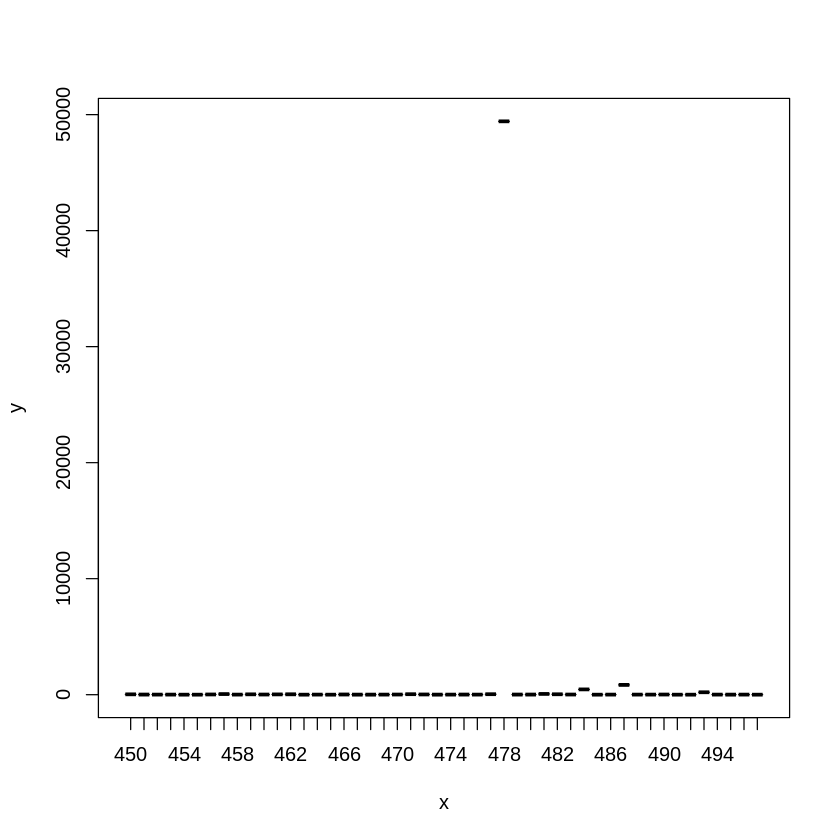

In [15]:
length.histogram <- as.data.frame(table(nchar(getSequences(seqtab.filt))))
len.plt <- plot(x=length.histogram[,1], y=length.histogram[,2])
len.plt
pdf(paste(wdpath, "img/", "length_hist.pdf", sep=""))
len.plt
dev.off()

### 15. Remove chimeras

In [16]:
seqtab.nochim <- removeBimeraDenovo(seqtab.filt, method="pooled", multithread=T, verbose=T)
dim(seqtab.nochim)
sum(seqtab.nochim)/sum(seqtab.filt)

Identified 28765 bimeras out of 51531 input sequences.



[1]   969 22766

[1] 0.9213317

### 16. Processing summary

In [17]:
getN <- function(x) sum(getUniques(x))
track <- cbind(out, sapply(dadaFs, getN), sapply(dadaRs, getN), sapply(mergers, getN), rowSums(seqtab.nochim))
colnames(track) <- c("input", "filtered", "denoisedF", "denoisedR", "merged", "nochimeras")
rownames(track) <- sample.names
track

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.



,input,filtered,denoisedF,denoisedR,merged,nochimeras
2L13-PD1,53293,43742,43182,41889,39921,35110
2L13-PE1,51802,41455,40735,40028,37603,31739
2L13-PF1,50704,44991,44264,43700,40200,36086
2L17-PE1,56847,50544,49907,49242,45028,40345
2L17-PF1,56009,49541,48701,48466,43611,37464
2L2-PD1,50309,40624,40142,40531,29489,28290
2L2-PE1,62524,54860,53918,53038,49591,45293
2L23-PD1,40489,33113,32653,32158,31171,28168
2L23-PE1,60126,48884,47955,46466,42639,39322
2L3-PF1,38961,33907,33625,33358,30479,29518


### 17. Save output

In [18]:
write.table(data.frame("row_names"=rownames(track),track),"read_retention.txt", row.names=FALSE, quote=F, sep="\t")
uniquesToFasta(seqtab.nochim, "rep_set.fa")
system("awk '/^>/{print \">ASV\" ++i; next}{print}' < rep_set.fa > rep_set_fix.fa")
system("mv rep_set_fix.fa rep_set.fa")

### 18. Clean up ASV names

In [19]:
my_otu_table <- t(as.data.frame(seqtab.nochim)) 
ASV.seq <- as.character(unclass(row.names(my_otu_table))) 
ASV.num <- paste0("ASV", seq(ASV.seq), sep='') 
colnames(seqtab.nochim) <- ASV.num 
write.table(data.frame("row_names"=rownames(seqtab.nochim),seqtab.nochim),"sequence_table.merged.txt", row.names=FALSE, quote=F, sep="\t")

### 19. 